initial setup

In [1]:
%matplotlib inline
import psrchive as psr
import matplotlib.pyplot as plt
import numpy as np

Load the archive and scrunch it in polarisation and time domains

In [2]:
ar = psr.Archive_load("total.ZZc")
ar.pscrunch()
ar.tscrunch()

Get the data and estimate the baseline as a function of frequency. Get rid of the dimensions which have already been scrunched. 

In [3]:
subint = ar.get_Integration(0)
(bl_mean, bl_var) = subint.baseline_stats()
bl_mean = bl_mean.squeeze()
bl_var = bl_var.squeeze()
non_zeroes = np.where(bl_mean != 0.0)

Get the frequencies from the archive. Not terribly efficient, is there a better way to do this?

In [4]:
min_freq = ar.get_Profile(0, 0, 0).get_centre_frequency()
max_freq = ar.get_Profile(0, 0, ar.get_nchan()-1).get_centre_frequency()

Associate the baseline stats with the corresponding RF. 

Plot the bandpass estimate.

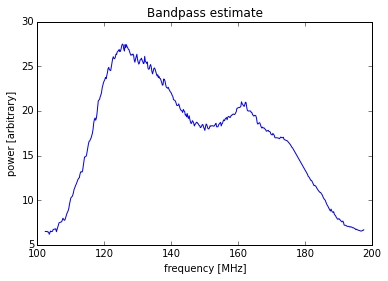

In [5]:
freqs = np.linspace(min_freq, max_freq, ar.get_nchan())
fig1 = plt.plot(freqs[non_zeroes],bl_mean[non_zeroes])
xlab = plt.xlabel('frequency [MHz]')
ylab = plt.ylabel('power [arbitrary]')
title = plt.title("Bandpass estimate")

Get data and use the peak value as an estimate of flux. For this pulsar (J1509+5531) this should work OK. Note that we haven't removed the baseline yet so this is only a test really.

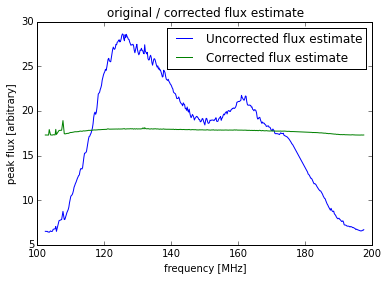

In [6]:
data =ar.get_data()
data = data.squeeze()
peak_value = np.amax(data, axis=1)
peak_value_line, = plt.plot(freqs[non_zeroes],peak_value[non_zeroes], label="Uncorrected flux estimate")
peak_values_corrected = peak_value[non_zeroes] / bl_mean[non_zeroes] * np.average(bl_mean[non_zeroes])
peak_value_corrected_line, = plt.plot(freqs[non_zeroes],peak_values_corrected, label="Corrected flux estimate")
xlab = plt.xlabel('frequency [MHz]')
ylab = plt.ylabel('peak flux [arbitrary]')
title = plt.title("original / corrected flux estimate")
legend = plt.legend(handles=[peak_value_line, peak_value_corrected_line])

Now repeat the process for data after baseline removal, which is what is ultimately of interest. Essentially the same as above otherwise.

We start by preparing the data and getting the estimators:

In [7]:
ar.remove_baseline()
data_br = ar.get_data()
data_br = data_br.squeeze()
peak_value_br = np.amax(data_br, axis=1)
peak_value_br_corrected = peak_value_br[non_zeroes] / bl_mean[non_zeroes] * np.average(bl_mean[non_zeroes])

And now plot them:

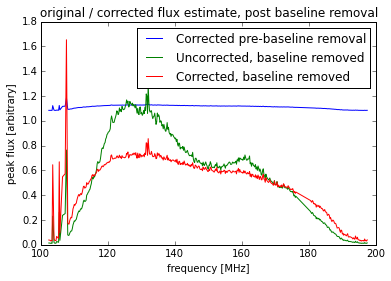

In [8]:
peak_value_line, = plt.plot(freqs[non_zeroes], peak_values_corrected / np.average(bl_mean), label="Corrected pre-baseline removal")
peak_value_br_line, = plt.plot(freqs[non_zeroes], peak_value_br[non_zeroes], label="Uncorrected, baseline removed")
peak_value_br_corrected_line, = plt.plot(freqs[non_zeroes], peak_value_br_corrected, label="Corrected, baseline removed")
xlab = plt.xlabel('frequency [MHz]')
ylab = plt.ylabel('peak flux [arbitrary]')
title = plt.title('original / corrected flux estimate, post baseline removal')
legend = plt.legend(handles=[peak_value_line, peak_value_br_line, peak_value_br_corrected_line])

A fair portion of hte bandpass now looks pretty nice. Let's try to measure the spectral index from the part of the bandpass which looks good. At the moment that part is chosen by eye

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


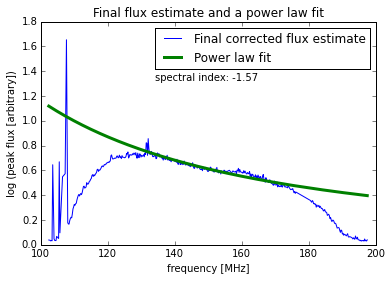

In [9]:
first=141
last=363
fit=np.polyfit(np.log10((freqs[non_zeroes])[first:last]), np.log10(peak_value_br_corrected[first:last]), 1)
peak_value_br_corrected_line, = plt.plot(freqs[non_zeroes], peak_value_br_corrected, label='Final corrected flux estimate')
peak_value_fit_line, = plt.plot(freqs[non_zeroes], np.power(10., np.log10(freqs[non_zeroes])*fit[0] + fit[1]), linewidth=3, label='Power law fit')
xlab = plt.xlabel('frequency [MHz]')
ylab = plt.ylabel('log (peak flux [arbitrary])')
fig4 = plt.text(freqs[ar.get_nchan()*1.67/5.], np.amax(peak_value_br_corrected) * 0.8,
                "spectral index: "+str(int(fit[0]*100)/100.))
title = plt.title("Final flux estimate and a power law fit")
legend = plt.legend(handles=[peak_value_br_corrected_line, peak_value_fit_line])